In [14]:
import torch
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import numpy as np
from math import pi
from collections import defaultdict
from autograd_lib import autograd_lib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")
from torchsummary import summary


In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, 190),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(190, 1))
    def forward(self, x):
        output = self.regressor(x)
        return output



(2500,)


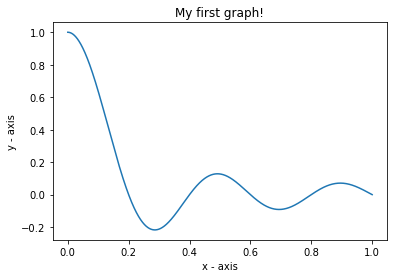

In [16]:
step = 0.1
X = np.linspace(1e-4, 1, 2500) 
y = np.sin(5*np.pi*X) / (5*np.pi*X)

import matplotlib.pyplot as plt
plt.plot(X, y)
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('My first graph!')
 
# function to show the plot
plt.show()



In [17]:
LR = 1e-4
MAX_EPOCH = 20000
BATCH_SIZE = 512

X_train, X_val, y_train, y_val = map(torch.tensor, train_test_split(X, y, test_size=0.2))
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)



In [18]:
# function to compute gradient norm
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms

    return grad_mean


# helper function to save activations
def save_activations(layer, A, _):
    '''
    A is the input of the layer, we use batch size of 6 here
    layer 1: A has size of (6, 1)
    layer 2: A has size of (6, 128)
    '''
    activations[layer] = A

# helper function to compute Hessian matrix
def compute_hess(layer, _, B):
    '''
    B is the backprop value of the layer
    layer 1: B has size of (6, 128)
    layer 2: B ahs size of (6, 1)
    '''
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) # do batch-wise outer product

    # full Hessian
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA) # do batch-wise outer product, then sum over the batch
    
# function to compute the minimum ratio
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    # compute Hessian matrix
    # save the gradient of each layer
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    # compute eigenvalues of the Hessian matrix
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) # compute mean of minimum ratio

    return ratio_mean


In [27]:
def returnLossPredictedOp(model, train_dataloader, val_dataloader):
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    
    # training loop
    train_loss_list = list()
    val_loss_list = list()
    gradient_norm=[]
    minimal_ratio=[]
    for epoch in range(MAX_EPOCH):
        print("epoch %d / %d" % (epoch+1, MAX_EPOCH))
        model.train()
     
        # training loop
        temp_loss_list = list()
        grdnt_norm=0
        min_ratio=0
        for X_train, y_train in train_dataloader:
            X_train = X_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.float32).to(device)

            optimizer.zero_grad()

            score = model(X_train)
            loss = criterion(input=score, target=y_train)
            #loss.requires_grad = True
            loss.backward()

            optimizer.step()

            temp_loss_list.append(loss.detach().cpu().numpy())
            grdnt_norm += compute_gradient_norm(model, criterion, X_train, y_train)
            min_ratio += compute_minimum_ratio(model, criterion, X_train, y_train)

        train_loss_list.append(np.average(temp_loss_list))
        gradient_norm.append(np.average(grdnt_norm))
        minimal_ratio.append(np.average(min_ratio))
        print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm[-1], minimal_ratio[-1]))
        # validation
        model.eval()

        temp_loss_list = list()

        for X_val, y_val in val_dataloader:
            X_val = X_val.type(torch.float32).to(device)
            y_val = y_val.type(torch.float32).to(device)

            score = model(X_val)        
            loss = criterion(input=score, target=y_val)

            temp_loss_list.append(loss.detach().cpu().numpy())

        val_loss_list.append(np.average(temp_loss_list))

        print("\ttrain loss: %.5f" % train_loss_list[-1])
        print("\tval loss: %.5f" % val_loss_list[-1])
    
    return train_loss_list, val_loss_list, gradient_norm, minimal_ratio

In [28]:
activations = defaultdict(int)
hess = defaultdict(float)
model = SineApproximator().to(device)
autograd_lib.register(model)
t_ls_1, v_ls_1, gradient_norm, minimal_ratio = returnLossPredictedOp(model, train_dataloader, val_dataloader)

epoch 1 / 20000
gradient norm: 5.86878989636898, minimum ratio: 2.3684210526315788
	train loss: 0.15900
	val loss: 0.15346
epoch 2 / 20000
gradient norm: 5.372600853443146, minimum ratio: 2.439473684210526
	train loss: 0.14903
	val loss: 0.14422
epoch 3 / 20000
gradient norm: 4.892411842942238, minimum ratio: 2.394736842105263
	train loss: 0.14008
	val loss: 0.13595
epoch 4 / 20000
gradient norm: 4.41388988122344, minimum ratio: 2.4000000000000004
	train loss: 0.13185
	val loss: 0.12864
epoch 5 / 20000
gradient norm: 3.9540716372430325, minimum ratio: 2.4342105263157894
	train loss: 0.12444
	val loss: 0.12228
epoch 6 / 20000
gradient norm: 3.5135993771255016, minimum ratio: 2.4368421052631577
	train loss: 0.11825
	val loss: 0.11684
epoch 7 / 20000
gradient norm: 3.0995533424429595, minimum ratio: 2.4368421052631577
	train loss: 0.11300
	val loss: 0.11226
epoch 8 / 20000
gradient norm: 2.7266969489865005, minimum ratio: 2.4210526315789473
	train loss: 0.10873
	val loss: 0.10849
epoch 9 

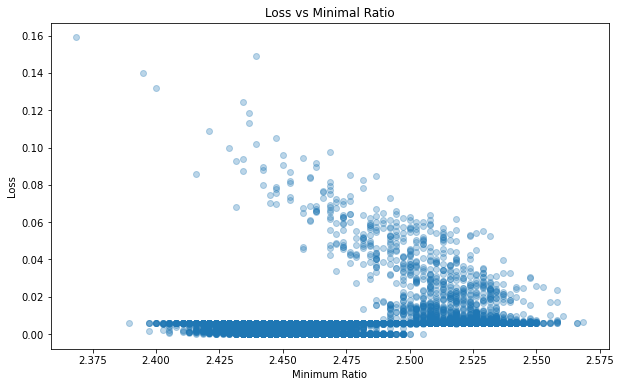

In [31]:
import matplotlib.pyplot as plt

plt_1 = plt.figure(figsize=(10, 6))
plt.title("Loss vs Minimal Ratio")
plt.scatter(minimal_ratio, t_ls_1, alpha=0.3)
plt.xlabel('Minimum Ratio')
plt.ylabel('Loss')
plt.show()